In [384]:
import numpy as np
import matplotlib.pyplot as plt
import galois
from classical_code import *
from quantum_code import *
import os

In [441]:
GF = galois.GF(2)

def repetition_code(n, boundary=False):
    H = np.zeros((n if boundary else n-1,n))
    for i in range(n if boundary else n-1):
        H[i][i] = H[i][(i+1)%n] = 1
    return H.astype(int)

H = np.zeros((ccode.m, ccode.n), dtype=int)
for i in range(ccode.m):
    for j in range(ccode.n):
        if (j in ccode.check_nbhd[i]):
            H[i][j] = 1

H = repetition_code(8, boundary=False)

m, n = H.shape
print(H)


[[1 1 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0]
 [0 0 1 1 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 0 0 0 1 1 0 0]
 [0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 1 1]]


In [442]:
def gaussian_reduction(H):
    m, n = H.shape

    H = GF(H)
    Hhat = GF(H.copy())
    K = GF(np.eye(n, dtype=int))
    pik = set(np.arange(n))

    for j in range(n):
        i = 0
        while ((i < m-1) and (Hhat[i][j] != 1)):
            i += 1
        if Hhat[i][j] == 1:
            pik ^= {j}
            for l in range(j+1, n):
                if Hhat[i][l] == 1:
                    Hhat[:,l] = Hhat[:,j] ^ Hhat[:,l]
                    K[:,l] = K[:,j] ^ K[:,l]

    return K, pik

In [443]:
Lx = []
Lz = []

K, pik = gaussian_reduction(H)
I = np.eye(n, dtype=int)

for i in pik:
    for j in pik:
        tmp = np.kron(K[:,i], I[:,j])
        Lz.append(np.concatenate([tmp, np.zeros(m**2, dtype=int)]))

        tmp = np.kron(I[:,i], K[:,j])
        Lx.append(np.concatenate([tmp, np.zeros(m**2, dtype=int)]))

K, pik = gaussian_reduction(H.T)
I = np.eye(H.T.shape[1], dtype=int)

for i in pik:
    for j in pik:
        tmp = np.kron(K[:,i], I[:,j])
        Lx.append(np.concatenate([np.zeros(n**2, dtype=int), tmp]))

        tmp = np.kron(I[:,i], K[:,j])
        Lz.append(np.concatenate([np.zeros(n**2, dtype=int), tmp]))

Lx = np.array(Lx)
Lz = np.array(Lz)

In [444]:
for l in Lx:
    print(np.count_nonzero(l))

8


In [445]:
H = np.array(H)
Hx = np.hstack([np.kron(H, np.eye(H.shape[1], dtype=int)), np.kron(np.eye(H.shape[0], dtype=int), H.T)])
Hz = np.hstack([np.kron(np.eye(H.shape[1], dtype=int), H), np.kron(H.T, np.eye(H.shape[0], dtype=int))])
cm, cn = Hx.shape

Hx_inds = [np.where(Hx[i])[0] for i in range(Hx.shape[0])]
Hz_inds = [np.where(Hz[i])[0] for i in range(Hz.shape[0])]

xL_inds = [np.where(x)[0] for x in Lx]
zL_inds = [np.where(z)[0] for z in Lz]
k = len(xL_inds)

qcode = QuantumCode(cn, k, Hz.shape[0], Hz.shape[0],
                    0, 0,
                    Hx_inds, Hz_inds, xL_inds, zL_inds, [])
write_qcode("../codes/qcodes/" + f"/HGP_{cn}_{k}.qcode", qcode)


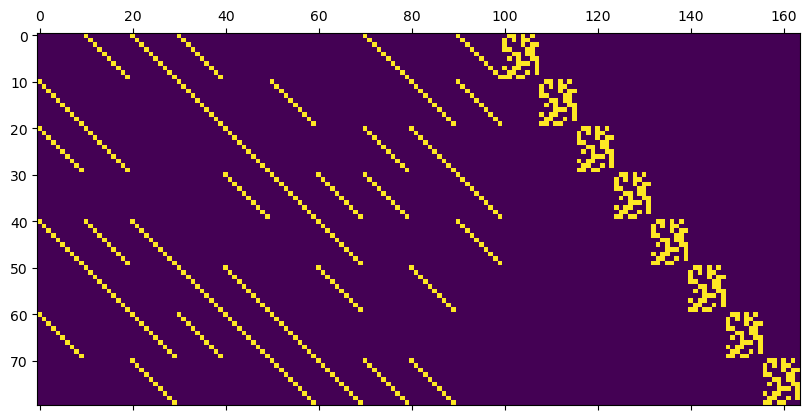

In [370]:
plt.matshow(np.array(Hx))

In [371]:
np.count_nonzero(Hx, axis=1)

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], dtype=int64)

In [372]:
xgens = []
zgens = []

for i in range(Hx.shape[0]):
    xgens.append((Hx[i][:n**2].reshape(n,n), Hx[i][n**2:].reshape(m,m)))
    zgens.append((Hz[i][:n**2].reshape(n,n), Hz[i][n**2:].reshape(m,m)))

xlogs = []
zlogs = []
for i in range(Lx.shape[0]):
    xlogs.append((Lx[i][:n**2].reshape(n,n), Lx[i][n**2:].reshape(m,m)))
    zlogs.append((Lz[i][:n**2].reshape(n,n), Lz[i][n**2:].reshape(m,m)))

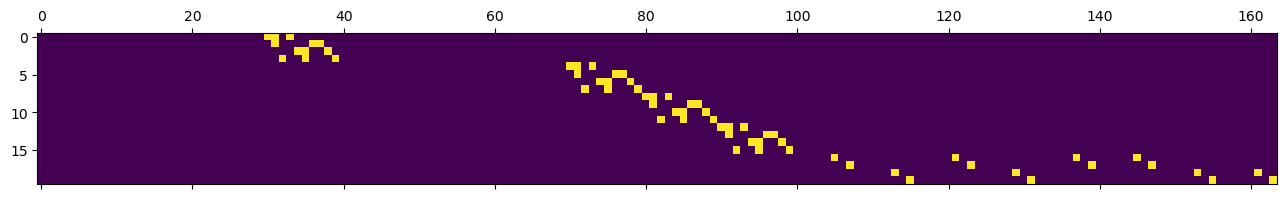

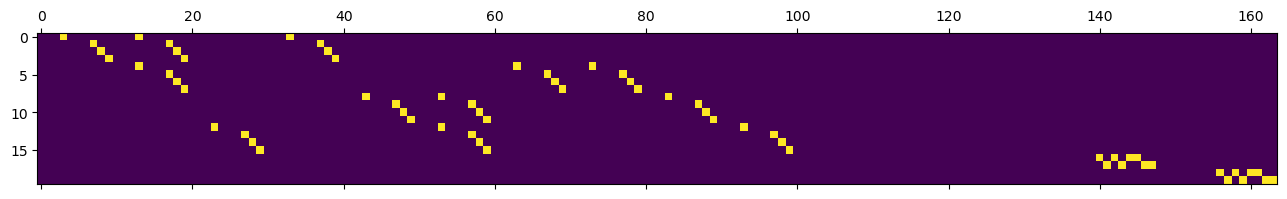

In [373]:
plt.matshow(Lx)
plt.matshow(Lz)

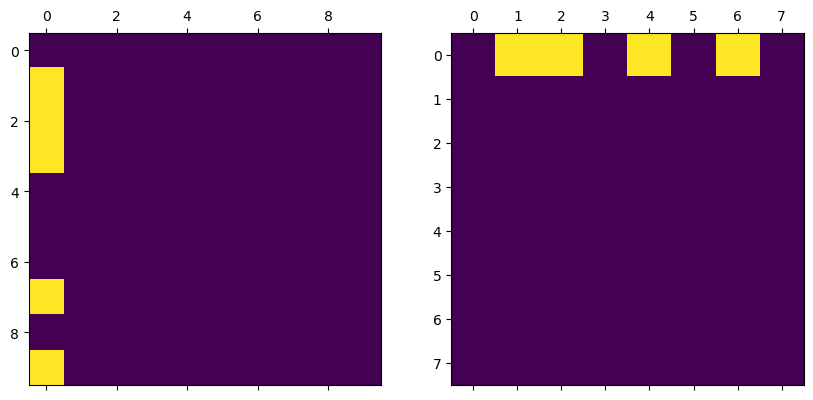

In [374]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False)

axes[0].matshow(xgens[0][0])
axes[1].matshow(xgens[0][1])

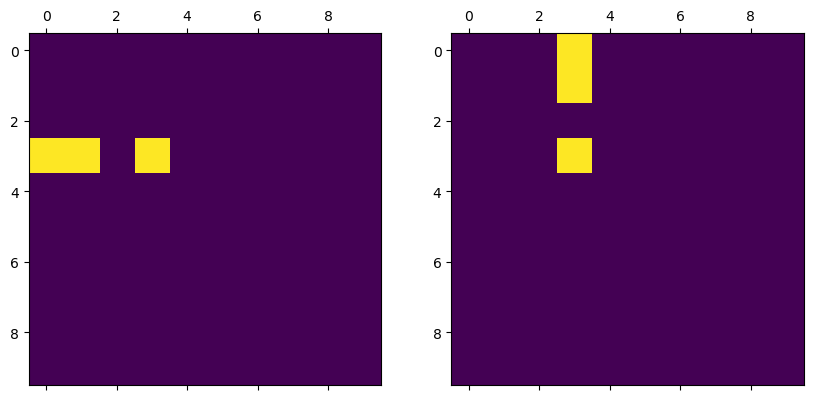

In [375]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False)

ind = 0
axes[0].matshow(xlogs[ind][0])
axes[1].matshow(zlogs[ind][0])

In [376]:
inds = np.arange(Hx.shape[1])
left, right = (inds[:n**2].reshape(n,n), inds[n**2:].reshape(m,m))
print(left)
print(right)

[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]
[[100 101 102 103 104 105 106 107]
 [108 109 110 111 112 113 114 115]
 [116 117 118 119 120 121 122 123]
 [124 125 126 127 128 129 130 131]
 [132 133 134 135 136 137 138 139]
 [140 141 142 143 144 145 146 147]
 [148 149 150 151 152 153 154 155]
 [156 157 158 159 160 161 162 163]]


In [377]:
def assign_qubits(left, right):
    pairs = np.concatenate([np.diagonal(left), np.diagonal(right)]).reshape(-1, 2)

    upper_triangle_inds = np.triu_indices(left.shape[0], k=1)
    for i, j in zip(*upper_triangle_inds):
        tmp = np.array([left[i][j], left[j][i]])
        pairs = np.vstack([pairs, tmp])

    upper_triangle_inds = np.triu_indices(right.shape[0], k=1)
    for i, j in zip(*upper_triangle_inds):
        tmp = np.array([right[i][j], right[j][i]])
        pairs = np.vstack([pairs, tmp])

    return pairs

pairs = assign_qubits(left, right)
pairs

array([[  0,  11],
       [ 22,  33],
       [ 44,  55],
       [ 66,  77],
       [ 88,  99],
       [100, 109],
       [118, 127],
       [136, 145],
       [154, 163],
       [  1,  10],
       [  2,  20],
       [  3,  30],
       [  4,  40],
       [  5,  50],
       [  6,  60],
       [  7,  70],
       [  8,  80],
       [  9,  90],
       [ 12,  21],
       [ 13,  31],
       [ 14,  41],
       [ 15,  51],
       [ 16,  61],
       [ 17,  71],
       [ 18,  81],
       [ 19,  91],
       [ 23,  32],
       [ 24,  42],
       [ 25,  52],
       [ 26,  62],
       [ 27,  72],
       [ 28,  82],
       [ 29,  92],
       [ 34,  43],
       [ 35,  53],
       [ 36,  63],
       [ 37,  73],
       [ 38,  83],
       [ 39,  93],
       [ 45,  54],
       [ 46,  64],
       [ 47,  74],
       [ 48,  84],
       [ 49,  94],
       [ 56,  65],
       [ 57,  75],
       [ 58,  85],
       [ 59,  95],
       [ 67,  76],
       [ 68,  86],
       [ 69,  96],
       [ 78,  87],
       [ 79,

In [378]:
def iceberglogicals(n):
    icebergX = np.zeros(shape=(n-2,2), dtype=int)
    icebergZ = np.zeros(shape=(n-2,2), dtype=int)

    for i in range(n-2):
        icebergX[i] = np.array([0,i+1])
        icebergZ[i] = np.array([i+1,n-1])

    return icebergX, icebergZ

iceberg642Xlogicals = np.array([
    [1,2],
    [0,1],
    [4,5],
    [3,4],
])

iceberg642Zlogicals = np.array([
    [0,1],
    [1,2],
    [3,4],
    [4,5]
])

ibn = 4
ibk = ibn-2
icebergX = np.ones(ibn, dtype=int)
# icebergZ = np.ones(ibn, dtype=int)

# if (ibn == 6):
#     icebergXlogicals, icebergZlogicals = iceberg642Xlogicals, iceberg642Zlogicals
# else:
icebergXlogicals, icebergZlogicals = iceberglogicals(ibn)
print(icebergXlogicals)
print(icebergZlogicals)

[[0 1]
 [0 2]]
[[1 3]
 [2 3]]


In [379]:
# Hx, Hz, Lx, Lz = qcode.to_numpy()
concatenatedStabilizersQED = np.kron(np.eye(Hx.shape[1]//ibk, dtype=int), icebergX) # ibk | Hx.shape[1] required

concatenatedStabilizersXQEC = np.zeros(shape=(Hx.shape[0], concatenatedStabilizersQED.shape[1]), dtype=int)
concatenatedStabilizersZQEC = np.zeros(shape=(Hz.shape[0], concatenatedStabilizersQED.shape[1]), dtype=int)

for i, r in enumerate(Hx):
    # print(np.where(r))
    for x in np.where(r)[0]:
        iceberg_block = np.where(pairs == x)[0][0]
        iceberg_log = np.where(pairs == x)[1][0]
        # print(iceberg_block, iceberg_log)
        concatenatedStabilizersXQEC[i][icebergXlogicals[iceberg_log]+(ibn*iceberg_block)] ^= 1

for i, r in enumerate(Hz):
    for z in np.where(r)[0]:
        iceberg_block = np.where(pairs == z)[0][0]
        iceberg_log = np.where(pairs == z)[1][0]
        concatenatedStabilizersZQEC[i][icebergZlogicals[iceberg_log]+(ibn*iceberg_block)] ^= 1

concatenatedHx = np.vstack([concatenatedStabilizersXQEC, concatenatedStabilizersQED][::-1])
concatenatedHz = np.vstack([concatenatedStabilizersZQEC, concatenatedStabilizersQED][::-1])

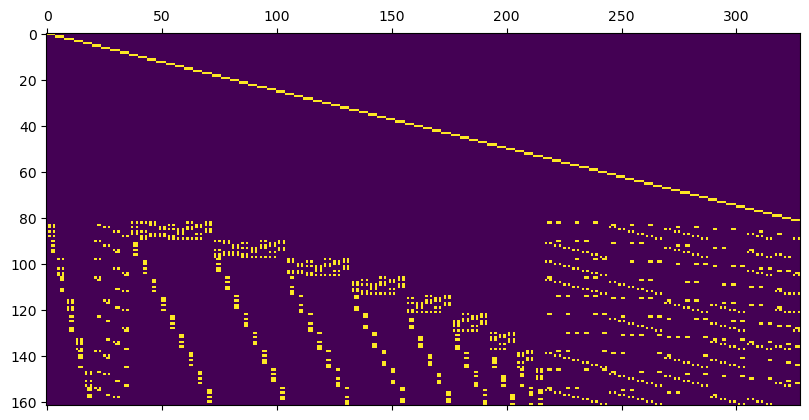

In [380]:
plt.matshow(concatenatedHz)

In [381]:
concatenatedxL = np.zeros(shape=(Lx.shape[0], concatenatedStabilizersQED.shape[1]), dtype=int)
concatenatedzL = np.zeros(shape=(Lz.shape[0], concatenatedStabilizersQED.shape[1]), dtype=int)

for i, r in enumerate(Lx):
    for x in np.where(r)[0]:
        iceberg_block = np.where(pairs == x)[0][0]
        iceberg_log = np.where(pairs == x)[1][0]
        # print(iceberg_block, iceberg_log)
        concatenatedxL[i][icebergXlogicals[iceberg_log]+(ibn*iceberg_block)] ^= 1

for i, r in enumerate(Lz):
    for z in np.where(r)[0]:
        iceberg_block = np.where(pairs == z)[0][0]
        iceberg_log = np.where(pairs == z)[1][0]
        concatenatedzL[i][icebergZlogicals[iceberg_log]+(ibn*iceberg_block)] ^= 1

xL_inds = [np.where(x)[0] for x in concatenatedxL]
zL_inds = [np.where(z)[0] for z in concatenatedzL]

m, n = concatenatedHx.shape
k = len(xL_inds)

Hx_inds = [np.where(concatenatedHx[i])[0] for i in range(concatenatedHx.shape[0])]
Hz_inds = [np.where(concatenatedHz[i])[0] for i in range(concatenatedHz.shape[0])]

qcode = QuantumCode(n, k, concatenatedHx.shape[0], concatenatedHz.shape[0],
                    concatenatedStabilizersQED.shape[0], concatenatedStabilizersQED.shape[0],
                    Hx_inds, Hz_inds, xL_inds, zL_inds, list(pairs))
write_qcode("../codes/qcodes/" + f"/HGP_C{ibn}{ibk}2_{n}_{k}.qcode", qcode)

In [382]:
zL_inds

[array([ 6,  7, 45, 47, 77, 79], dtype=int64),
 array([ 61,  63,  93,  95, 145, 147], dtype=int64),
 array([ 65,  67,  97,  99, 149, 151], dtype=int64),
 array([ 69,  71, 101, 103, 153, 155], dtype=int64),
 array([ 77,  79, 142, 143, 146, 147], dtype=int64),
 array([ 14,  15,  93,  95, 193, 195], dtype=int64),
 array([ 97,  99, 197, 199, 205, 207], dtype=int64),
 array([101, 103, 201, 203, 209, 211], dtype=int64),
 array([134, 135, 138, 139, 150, 151], dtype=int64),
 array([165, 167, 181, 183, 206, 207], dtype=int64),
 array([ 17,  19, 169, 171, 185, 187], dtype=int64),
 array([173, 175, 189, 191, 213, 215], dtype=int64),
 array([105, 107, 138, 139, 154, 155], dtype=int64),
 array([121, 123, 181, 183, 210, 211], dtype=int64),
 array([125, 127, 185, 187, 214, 215], dtype=int64),
 array([ 18,  19, 129, 131, 189, 191], dtype=int64),
 array([ 30,  31, 234, 235, 278, 279, 306, 307], dtype=int64),
 array([258, 259, 294, 295, 317, 319, 321, 323], dtype=int64),
 array([242, 243, 286, 287, 314,

In [383]:
xL_inds

[array([ 4,  6, 44, 46, 76, 78], dtype=int64),
 array([ 76,  78, 140, 141, 144, 145], dtype=int64),
 array([132, 133, 136, 137, 148, 149], dtype=int64),
 array([104, 106, 136, 137, 152, 153], dtype=int64),
 array([ 60,  62,  92,  94, 144, 146], dtype=int64),
 array([ 12,  14,  92,  94, 192, 194], dtype=int64),
 array([164, 166, 180, 182, 204, 205], dtype=int64),
 array([120, 122, 180, 182, 208, 209], dtype=int64),
 array([ 64,  66,  96,  98, 148, 150], dtype=int64),
 array([ 96,  98, 196, 198, 204, 206], dtype=int64),
 array([ 16,  17, 168, 170, 184, 186], dtype=int64),
 array([124, 126, 184, 186, 212, 213], dtype=int64),
 array([ 68,  70, 100, 102, 152, 154], dtype=int64),
 array([100, 102, 200, 202, 208, 210], dtype=int64),
 array([172, 174, 188, 190, 212, 214], dtype=int64),
 array([ 16,  18, 128, 130, 188, 190], dtype=int64),
 array([ 28,  30, 232, 233, 276, 277, 304, 305], dtype=int64),
 array([240, 241, 284, 285, 312, 313, 320, 321], dtype=int64),
 array([256, 257, 292, 293, 316,